# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland']

%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [3]:
final_results = pd.read_csv('data/rt.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['country', 'date'],
                            squeeze=True)

In [4]:
final_results

ML  Low_90  High_90  Low_50  High_50
country        date                                              
Austria        2020-03-10  3.57    1.60     5.28    2.70     4.21
               2020-03-11  3.55    2.32     4.70    3.03     4.00
               2020-03-12  3.48    2.54     4.34    3.03     3.77
               2020-03-13  3.32    2.56     4.03    2.97     3.57
               2020-03-14  2.93    2.25     3.53    2.63     3.15
...                         ...     ...      ...     ...      ...
United_Kingdom 2020-04-25  1.04    0.87     1.18    0.97     1.09
               2020-04-26  0.94    0.77     1.08    0.87     0.99
               2020-04-27  0.86    0.70     1.01    0.80     0.92
               2020-04-28  0.80    0.63     0.95    0.71     0.84
               2020-04-29  0.75    0.58     0.90    0.66     0.79

[1459 rows x 5 columns]

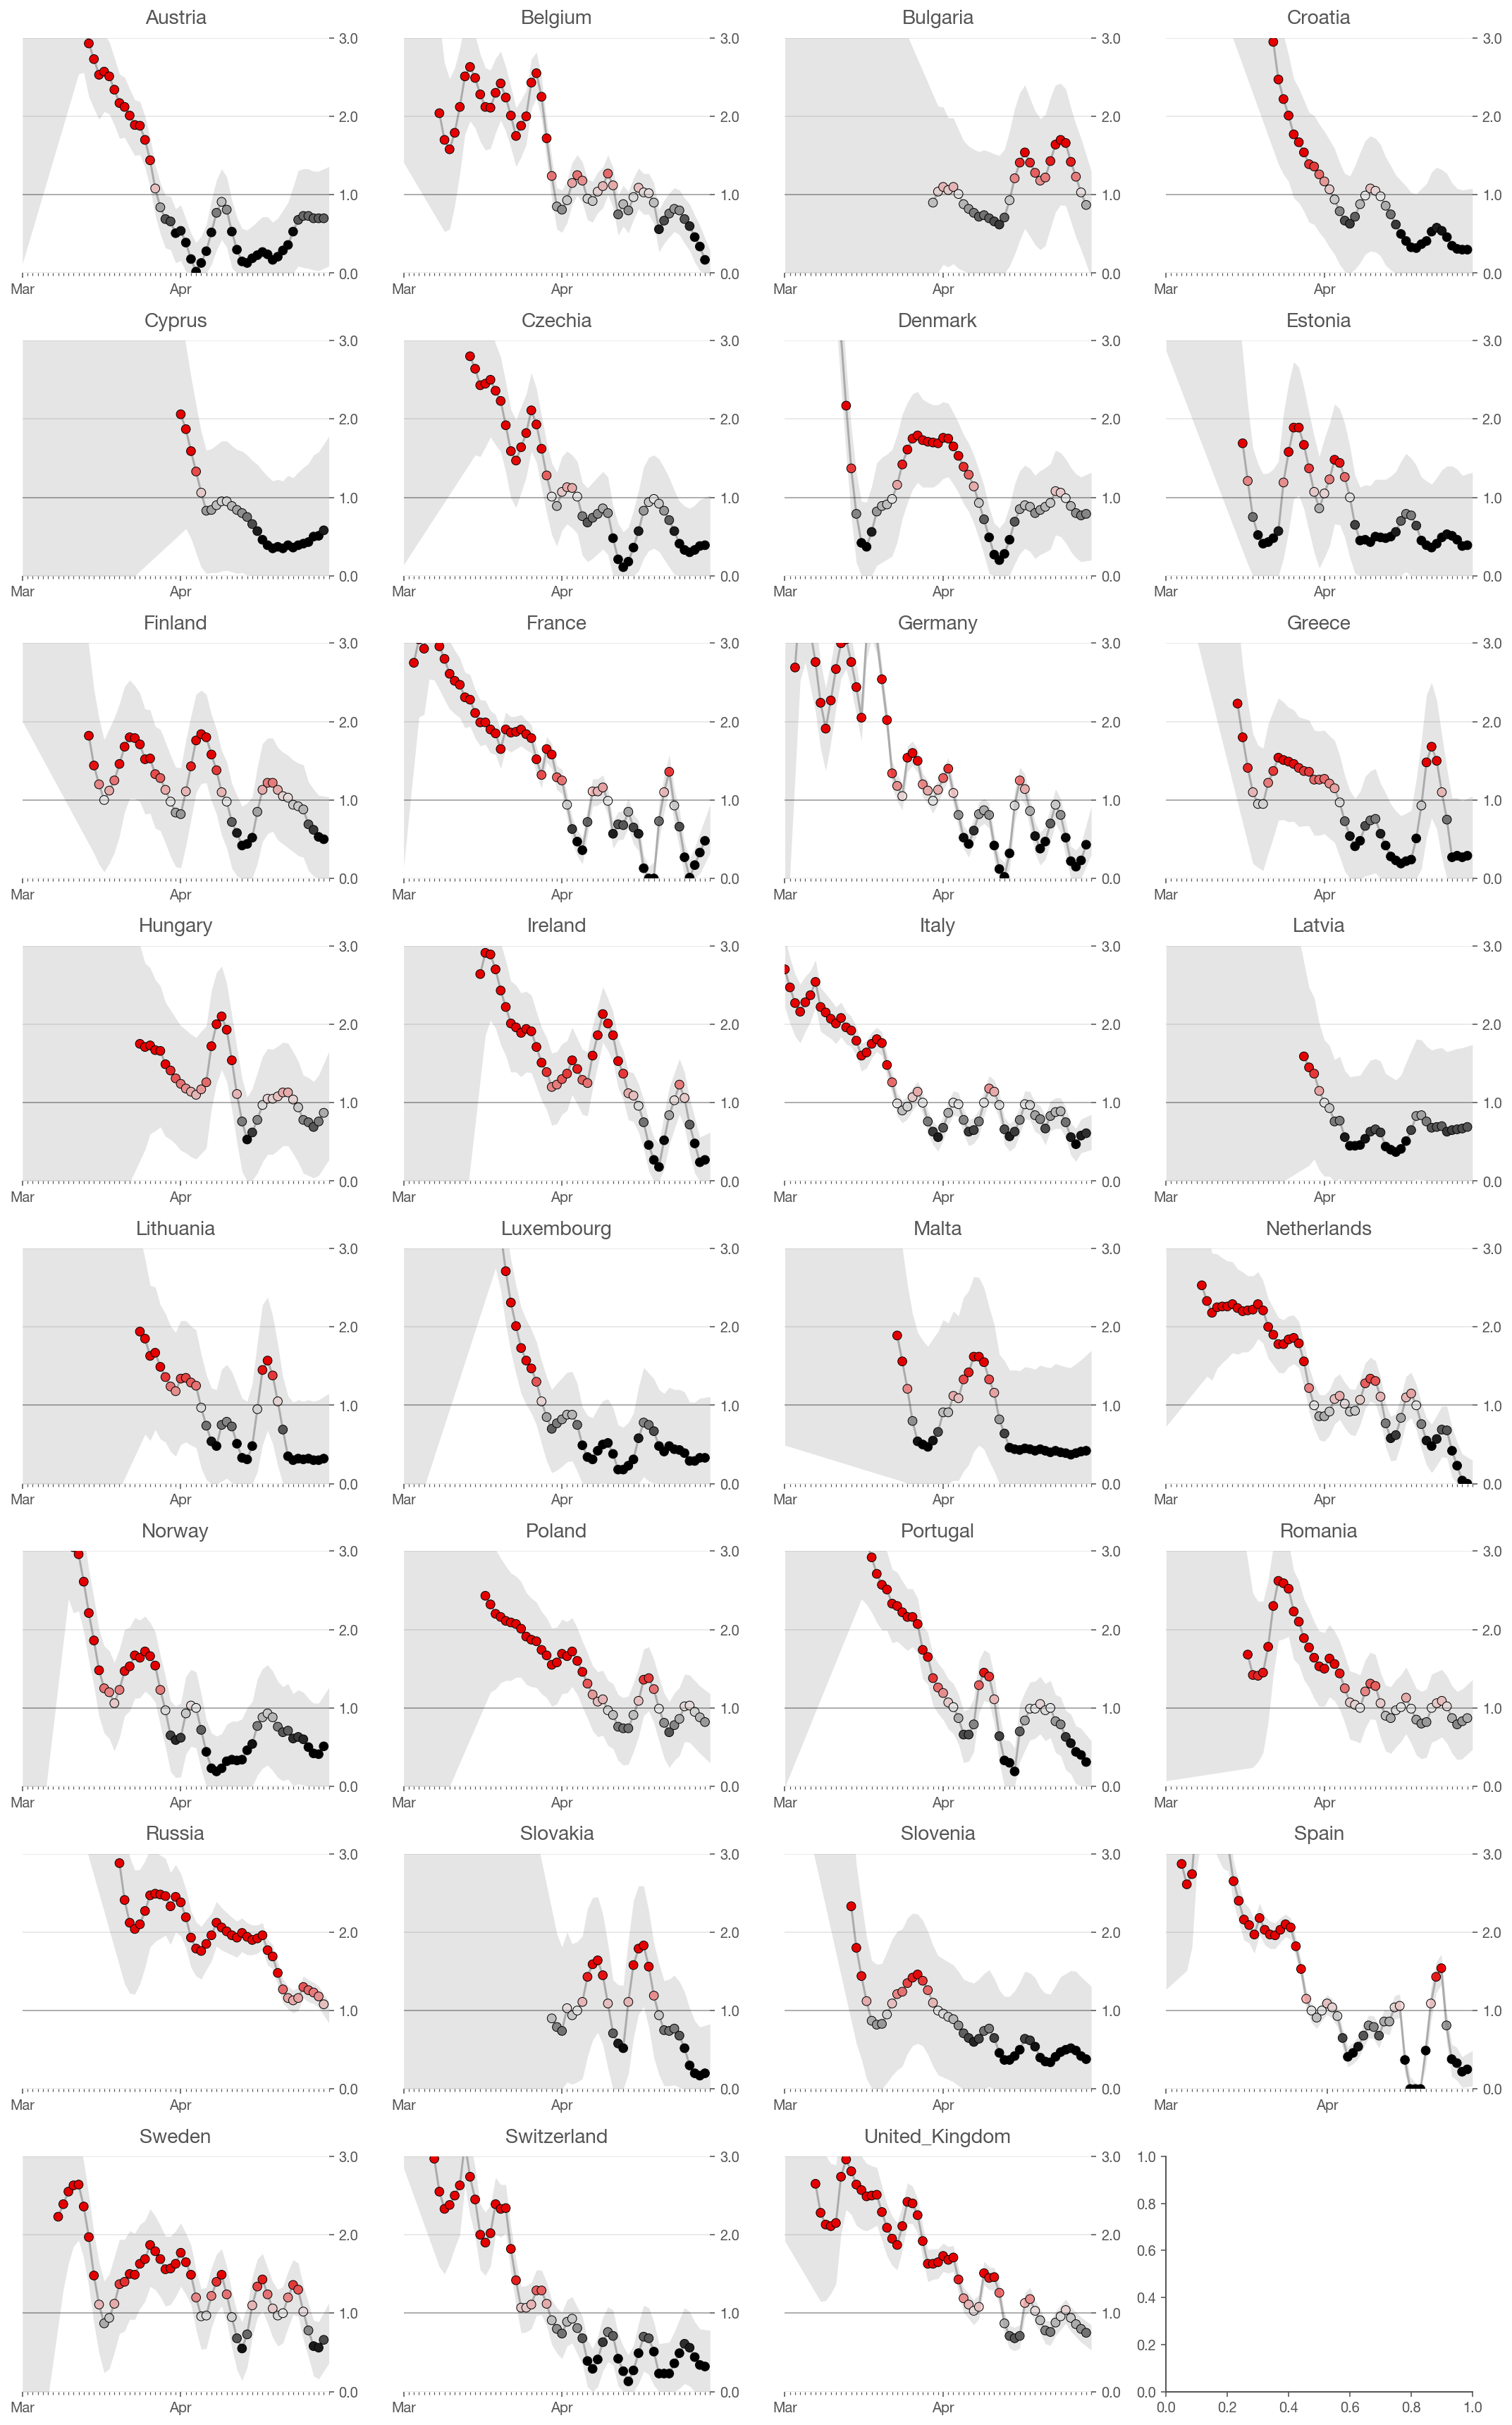

In [5]:
ncountries = len(final_results.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [6]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [7]:
no_lockdown = []
partial_lockdown = []

In [8]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv', 
                                    parse_dates=['date'],infer_datetime_format=True,
                                    index_col=['country', 'date'],
                                    squeeze=True)

In [9]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

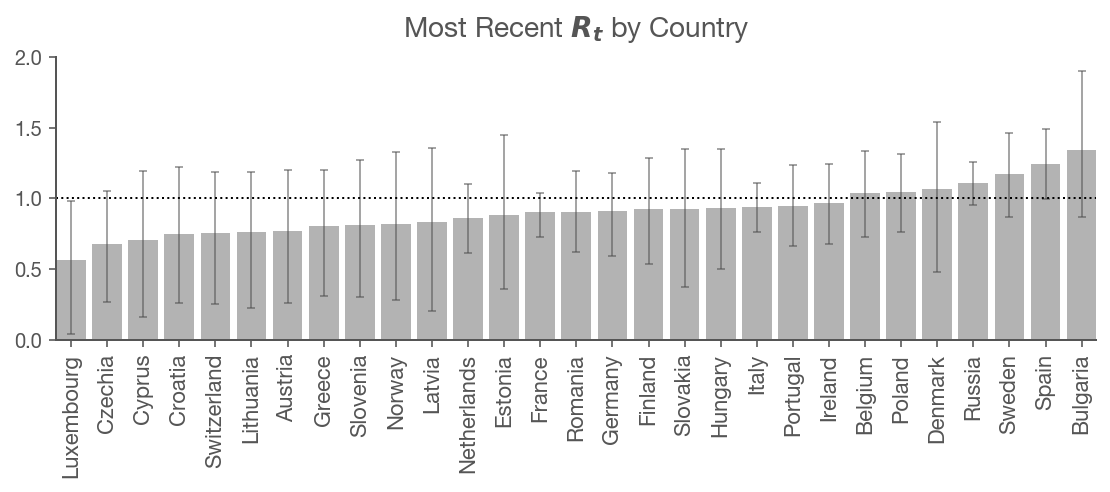

In [10]:
targets_rainier = final_results_rainier.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_rainier.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr_rainier)

## MCMC

In [11]:
final_results_mcmc = pd.read_csv('data/rt_mcmc.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [12]:
final_results_mcmc

mean    median  lower_90  upper_90  lower_50  \
region         date                                                           
Austria        2020-03-14  1.270801  1.240475  1.058555  1.525763  1.110952   
               2020-03-15  1.246741  1.219428  1.045406  1.467685  1.113420   
               2020-03-16  1.211277  1.191665  1.017751  1.390788  1.106066   
               2020-03-17  1.170501  1.153263  1.002182  1.338592  1.067374   
               2020-03-18  1.124691  1.113500  0.976379  1.300102  1.024472   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-04-27  1.044307  1.036719  0.958804  1.143102  0.997919   
               2020-04-28  1.066873  1.055413  0.957025  1.175157  0.994678   
               2020-04-29  1.088774  1.070879  0.971209  1.228041  1.007492   
               2020-04-30  1.099475  1.078463  0.952614  1.251288  1.008943   
               2020-05-01  1.102573  1.083475  0.954429  1.283351  1.011378   

                           upper_50  
region         date                  
Austria        2020-03-14  1.292624  
               2020-03-15  1.274963  
               2020-03-16  1.239230  
               2020-03-17  1.196671  
               2020-03-18  1.140181  
...                             ...  
United_Kingdom 2020-04-27  1.059539  
               2020-04-28  1.073085  
               2020-04-29  1.091921  
               2020-04-30  1.108509  
               2020-05-01  1.117081  

[1470 rows x 6 columns]

In [13]:
final_results_mcmc.columns = ['mean', 'ML', 'Low_90', 'High_90', 'Low_50', 'High_50']

In [14]:
final_results_mcmc

mean        ML    Low_90   High_90    Low_50  \
region         date                                                           
Austria        2020-03-14  1.270801  1.240475  1.058555  1.525763  1.110952   
               2020-03-15  1.246741  1.219428  1.045406  1.467685  1.113420   
               2020-03-16  1.211277  1.191665  1.017751  1.390788  1.106066   
               2020-03-17  1.170501  1.153263  1.002182  1.338592  1.067374   
               2020-03-18  1.124691  1.113500  0.976379  1.300102  1.024472   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-04-27  1.044307  1.036719  0.958804  1.143102  0.997919   
               2020-04-28  1.066873  1.055413  0.957025  1.175157  0.994678   
               2020-04-29  1.088774  1.070879  0.971209  1.228041  1.007492   
               2020-04-30  1.099475  1.078463  0.952614  1.251288  1.008943   
               2020-05-01  1.102573  1.083475  0.954429  1.283351  1.011378   

                            High_50  
region         date                  
Austria        2020-03-14  1.292624  
               2020-03-15  1.274963  
               2020-03-16  1.239230  
               2020-03-17  1.196671  
               2020-03-18  1.140181  
...                             ...  
United_Kingdom 2020-04-27  1.059539  
               2020-04-28  1.073085  
               2020-04-29  1.091921  
               2020-04-30  1.108509  
               2020-05-01  1.117081  

[1470 rows x 6 columns]

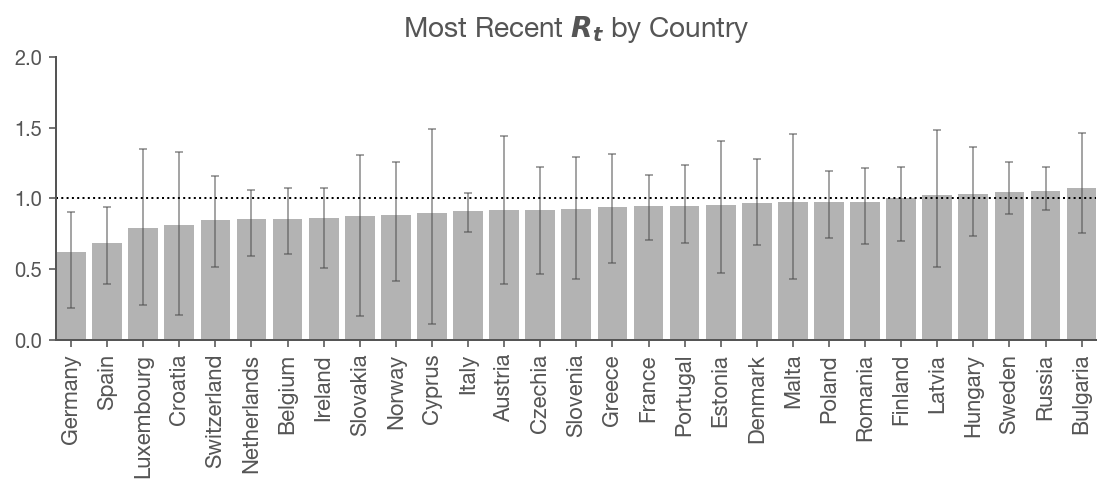

In [15]:
targets_mcmc = final_results_mcmc.index.get_level_values('region').isin(COUNTRIES_INCLUDED)
mr_mcmc = final_results_mcmc.loc[targets_mcmc].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_mcmc.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr_mcmc)

In [16]:
# export to be used on the website
fig.savefig('plots/standings.png', bbox_inches='tight', dpi=200)

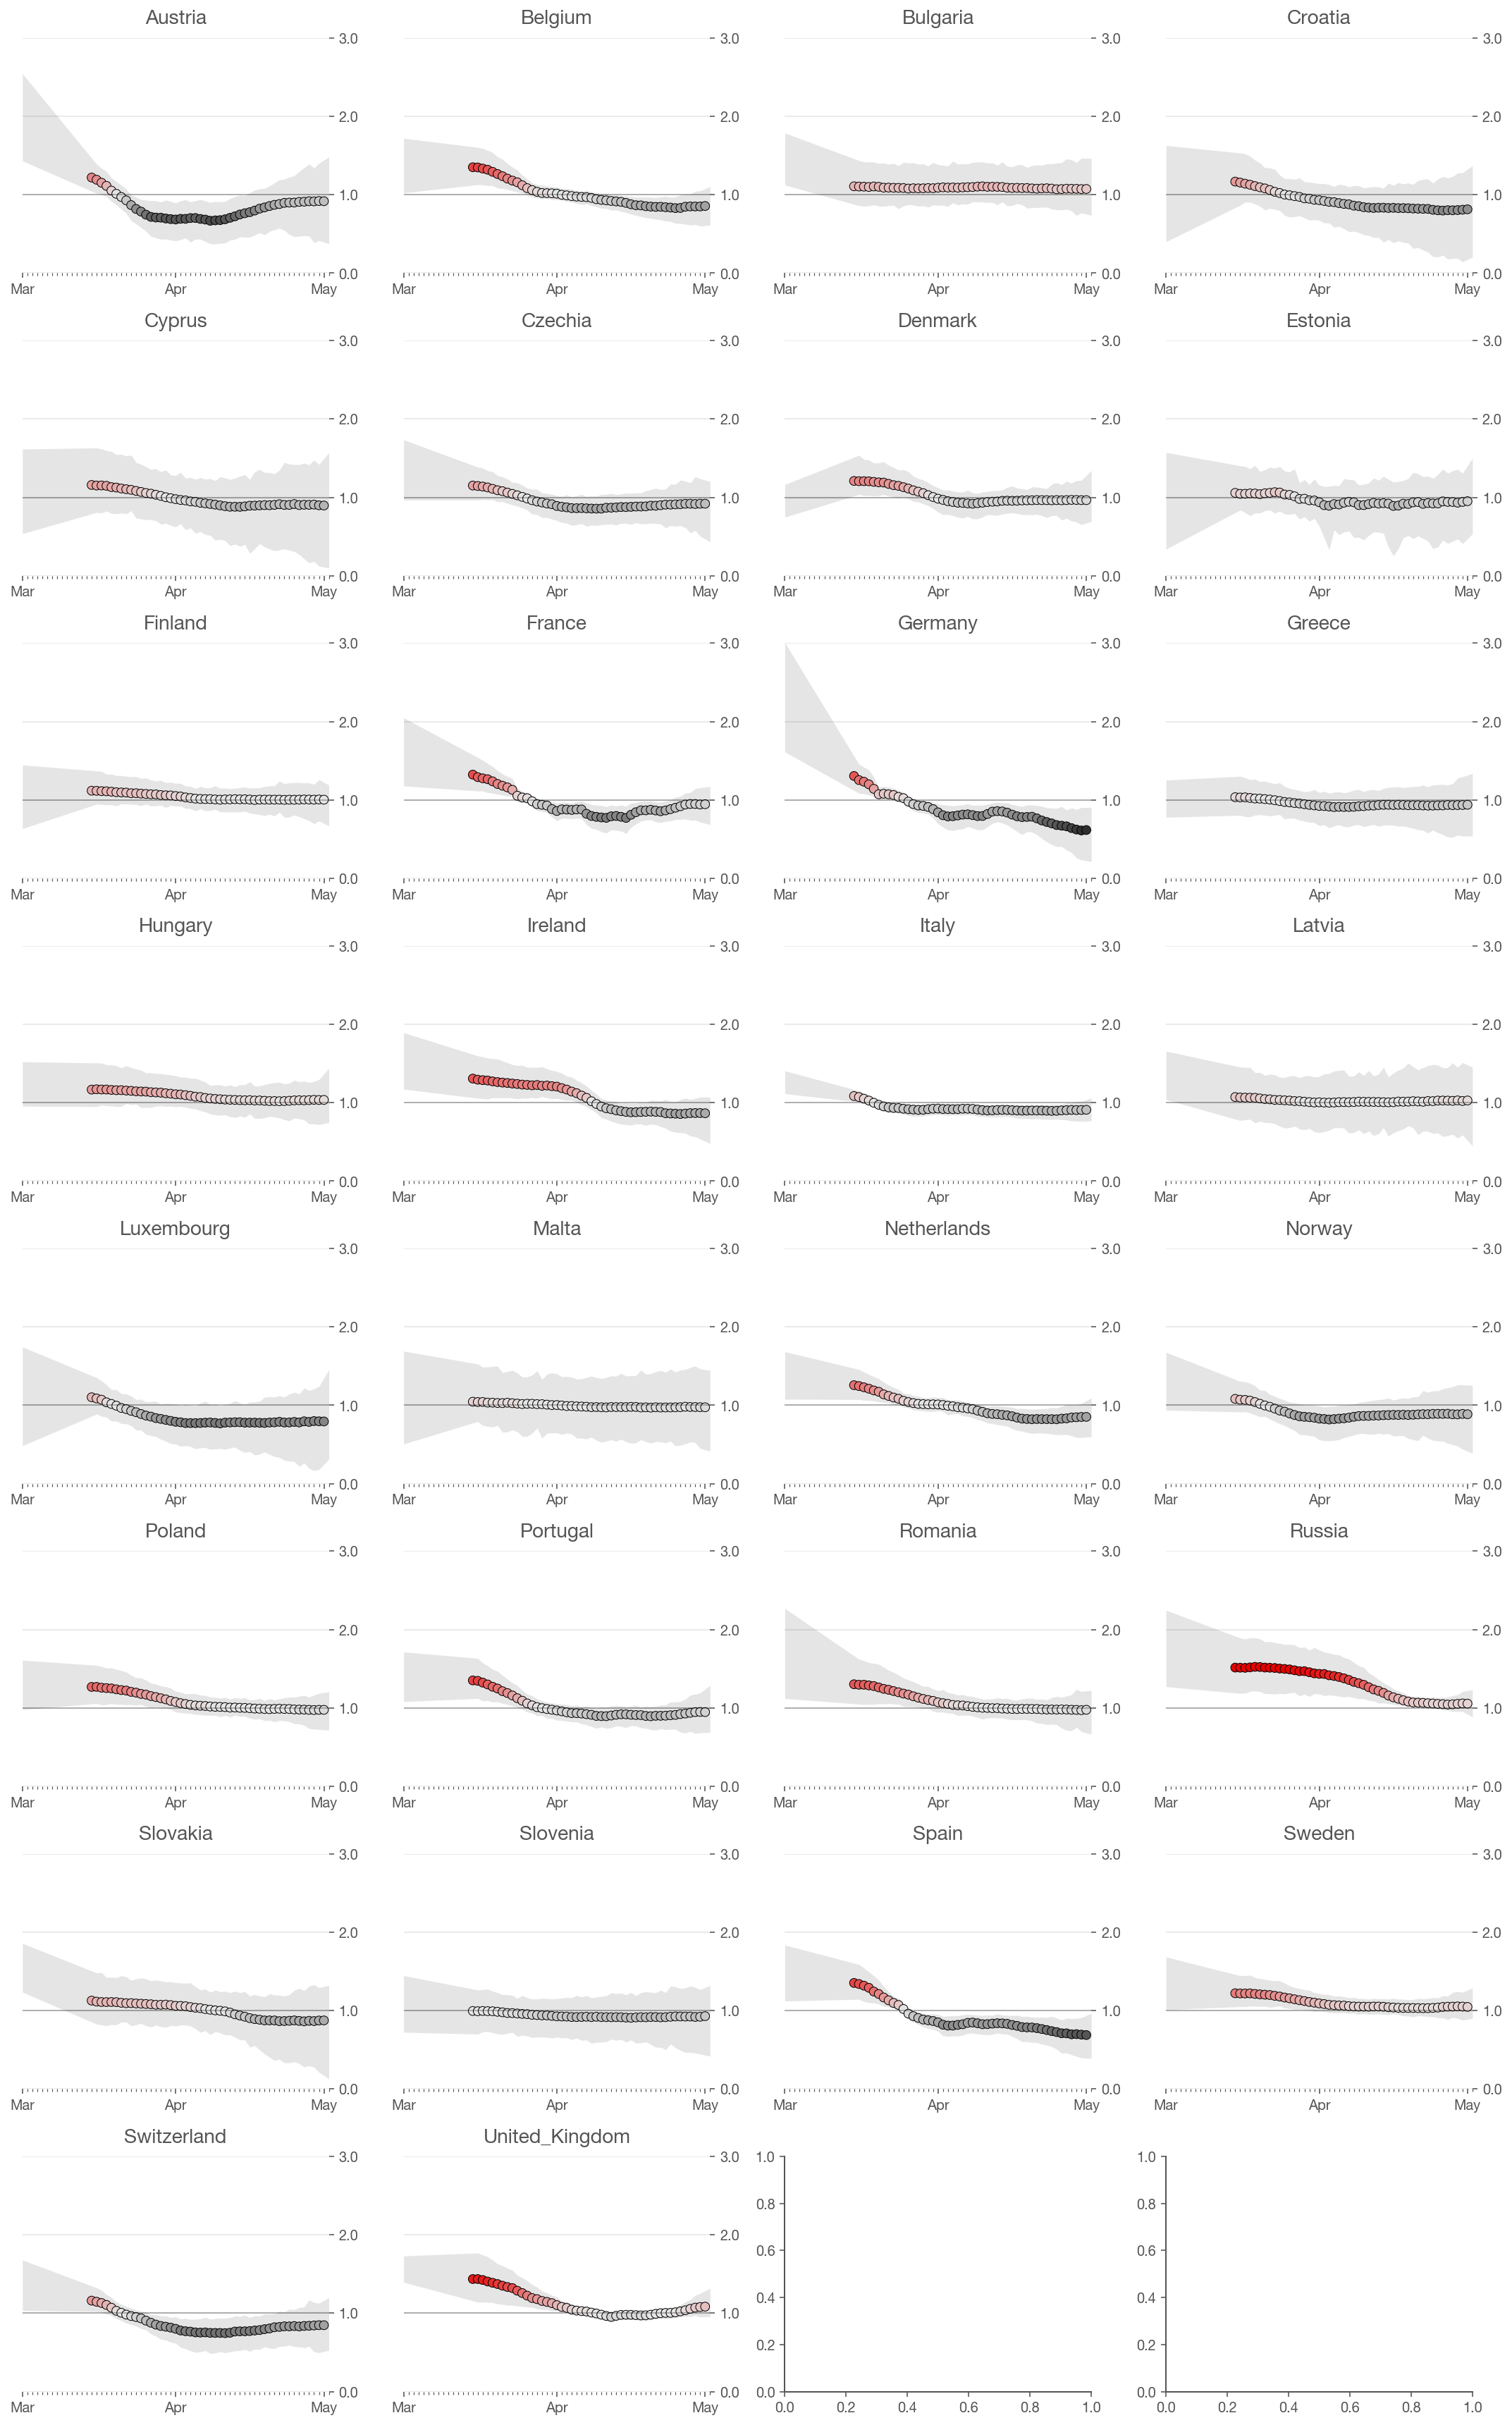

In [17]:
ncountries = len(final_results_mcmc.index.unique(level='region'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_mcmc.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

In [18]:
# export to be used on the website
fig.savefig('plots/countries.png', bbox_inches='tight', dpi=150)